# _Dataviz Code Session_: Séries Temporais

## Objetivos da DCS

- Aplicar técnicas de dataviz para plotagem e manipulação de séries temporais;
- Manipular séries temporais (STs) relativas a dados de repasses da arrecadação federal efetivados pela Secretaria Especial da Receita Federal do Brasil a outras entidades e fundos;
- Produzir representações visuais de STs e suas componentes fundamentais (tendência, sazonalidade e ruído);

## Ferramentas utilizadas

- Módulos Python
    - `pandas`
    - `sys`
    - `matplotlib`
    - `seaborn`
    - `statsmodels`
    - `numpy`

## Aplicação do modelo referencial

- Vide {numref}`Capítulo %s <cap:estetica>`.

In [1]:
from matplotlib.patches import Patch
from statsmodels.tsa.seasonal import seasonal_decompose

import pandas as pd, matplotlib.pyplot as plt, seaborn as sb, numpy as np
import sys; sys.path.insert(1,'../dcs')
import dcs27

plt.style.use('../etc/gcpeixoto-datavis.mplstyle') # style sheet

In [2]:
!cat ../dcs/dcs27.py

from pandas import read_csv, Series, to_datetime
from seaborn import lineplot

def load_data(keep_orig: True, show_links: False):
    """Load data from RFB on government resource transfer."""
    
    print('Extracting data from Receita Federal do Brasil...')
    
    # extract
    df_o = read_csv('https://www.gov.br/receitafederal/dados/repasse-s.csv',sep=';')
    df = df_o.copy()

    # transform
    m, y = [], []
    for i in df['Mês / Ano de Referência'].str.split('/'):
        m.append(i[0])
        y.append('20' + i[1]) 
    df['Mês'] = m
    df['Ano'] = y
    df['Total Repassado'] = df['Total Repassado'].str.replace('.','',regex=False).str.replace(',','.',regex=False).apply(lambda x: float(x))
    df = df.drop('Mês / Ano de Referência',axis=1)
    
    # load
    df = df[['Mês','Ano','Entidade','Total Repassado']]
    
    print('Data loaded successfully.')
    
    if show_links:
        print(f'Extracted from: https://www.gov.br/receitafederal/dados/repasse-s.csv\n')
        p

## Dados de entrada pré-processados

In [3]:
# carrega dados da RFB
df = dcs27.load_data(keep_orig=False,show_links=False)

Extracting data from Receita Federal do Brasil...
Data loaded successfully.


In [4]:
df

,Mês,Ano,Entidade,Total Repassado
0,jan,2015,FNDE,2.604078e+09
1,jan,2015,INCRA,1.814560e+08
2,jan,2015,SENAI,2.191193e+08
3,jan,2015,SESI,3.133701e+08
4,jan,2015,SENAC,3.340052e+08
...,...,...,...,...
1950,jul,2024,SENAT,4.856307e+07
1951,jul,2024,SESCOOP,6.016299e+07
1952,jul,2024,SDR,3.049184e+05
1953,jul,2024,APEX-BR,6.254455e+07


### Processamento adicional

- Listagem de entidades disponíveis para análise

In [5]:
# lista de entidades disponíveis
df['Entidade'].unique()

array(['FNDE', 'INCRA', 'SENAI', 'SESI', 'SENAC', 'SESC', 'SEBRAE',
       'EMBRATUR', 'DPC', 'ANAC', 'SENAR', 'SEST', 'SENAT', 'SESCOOP',
       'SDR', 'APEX-BR', 'ABDI'], dtype=object)

- Escolha de entidade e filtragem

In [6]:
entity = 'INCRA'
df_e = df[df['Entidade'] == entity].reset_index(drop=True)

## Mapeamento

- Criação de _string_ representativa de temporalidade;
- Conversão de _string_ para objeto `datetime`;
- Plotagem direta de curvas em eixos cartesianos;
    - Frequência mensal;
    - Frequência anual;

- Montagem de _string_ representativa da temporalidade (período)

In [7]:
df_e['Período'] = pd.Series([v['Mês'] + '/' + v['Ano'] for i,v in df_e.iterrows()])

In [8]:
df_e

,Mês,Ano,Entidade,Total Repassado,Período
0,jan,2015,INCRA,1.814560e+08,jan/2015
1,fev,2015,INCRA,1.062026e+08,fev/2015
2,mar,2015,INCRA,1.044018e+08,mar/2015
3,abr,2015,INCRA,1.042058e+08,abr/2015
4,mai,2015,INCRA,1.026660e+08,mai/2015
...,...,...,...,...,...
110,mar,2024,INCRA,2.073890e+08,mar/2024
111,abr,2024,INCRA,2.076833e+08,abr/2024
112,mai,2024,INCRA,2.159049e+08,mai/2024
113,jun,2024,INCRA,2.094306e+08,jun/2024


- Plotagem simples
    - Eixo emaranhado;
    - Falta de controle de espaçamento;

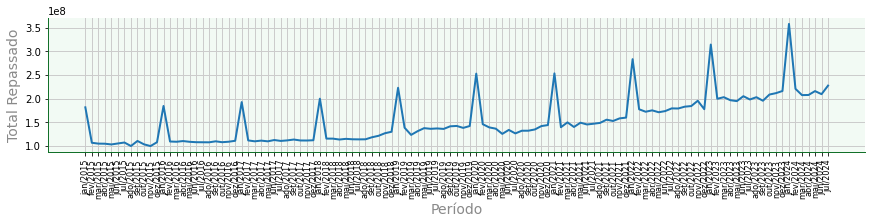

In [9]:
fig, ax = plt.subplots(figsize=(12,3),constrained_layout=True)
s1 = sb.lineplot(data=df_e,x='Período',y='Total Repassado',
                 #errorbar=None,
                 ax=ax)
ax.tick_params(axis='x', rotation=90, labelsize = 8)

- Transformação para objeto `datetime`

In [10]:
# ver função 'map_my' auxiliar
df_e['Período'] = pd.to_datetime(df_e['Período'].apply(lambda x: dcs27.map_my(x)))

## Visualização

### Iterando em RVs primárias

- Plotagem com eixo automaticamente controlado
    - Exploração de `seaborn.lineplot`
- Quadro de STs (frequência mensal)

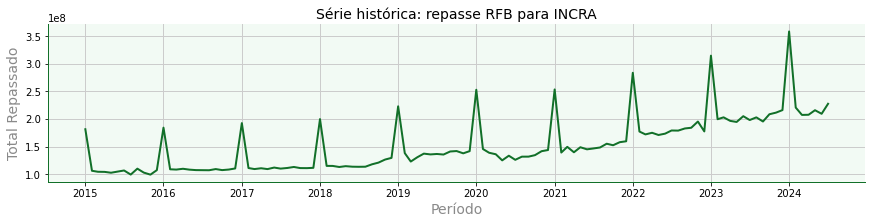

In [11]:
fig, ax = plt.subplots(figsize=(12,3),constrained_layout=True)
s1 = sb.lineplot(data=df_e,
                 x='Período', y='Total Repassado',
                 color=plt.rcParams['axes.edgecolor'], # cor do estilo customizado
                 #errorbar=None, 
                 ax=ax)
ax.set_title(f'Série histórica: repasse RFB para {entity}',fontsize=14);

- Plotagem de séries por frequência mensal

In [12]:
df_em = df_e.set_index('Ano')

In [13]:
df_em

,Mês,Entidade,Total Repassado,Período
Ano,,,,
2015,jan,INCRA,1.814560e+08,2015-01-01
2015,fev,INCRA,1.062026e+08,2015-02-01
2015,mar,INCRA,1.044018e+08,2015-03-01
2015,abr,INCRA,1.042058e+08,2015-04-01
2015,mai,INCRA,1.026660e+08,2015-05-01
...,...,...,...,...
2024,mar,INCRA,2.073890e+08,2024-03-01
2024,abr,INCRA,2.076833e+08,2024-04-01
2024,mai,INCRA,2.159049e+08,2024-05-01


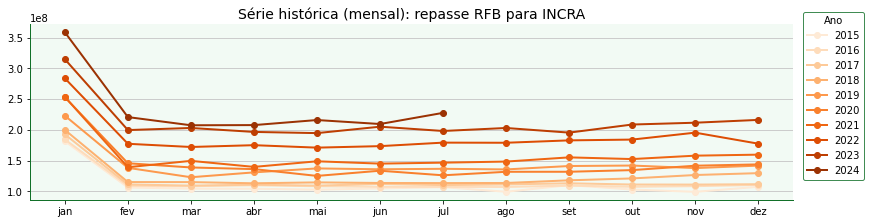

In [14]:
fig, ax = plt.subplots(figsize=(12,3),constrained_layout=True)

# paleta de cores
pal = sb.color_palette('Oranges',len(df_em.index.unique()))

# 
for i,y in enumerate(df_em.index.unique()):
#     sy = sb.lineplot(data=df_em,
#                      x=df_em.loc[y]['Mês'],
#                      y=df_em.loc[y]['Total Repassado'],
#                      marker='o',
#                      color=pal[i],
#                      #errorbar=None, 
#                      #ax=ax, 
#                      label=y)

        plt.plot(df_em.loc[y]['Mês'],df_em.loc[y]['Total Repassado'],'o-',color=pal[i],label=y)
    
    
ax.legend(loc='best', bbox_to_anchor=(1.1,1.1), title='Ano')
ax.grid(axis='x')
ax.set_title(f'Série histórica (mensal): repasse RFB para {entity}',fontsize=14);

- Identificação de componentes

**Nota 1**: STs podem ou não apresentar padrões. Padrões comuns são: i) tendência (comportamento monotônico); ii) sazonalidade (comportamento alternado devido a fatores sazonais); iii) híbrido (comportamento que apresenta tendências e efeitos sazonais combinados).

**Nota 2**: uma ST pode ser [descrita](https://cmapskm.ihmc.us/rid=1052458821502_1749267941_6906/components.pdf) por uma soma ou um produto de componentes:

- `statsmodels.tsa.seasonal_decompose` reproduz a ST observada e outras 3 componentes.

- ST aditiva: _valor = tendência + ciclo + sazonalidade + irregularidade_

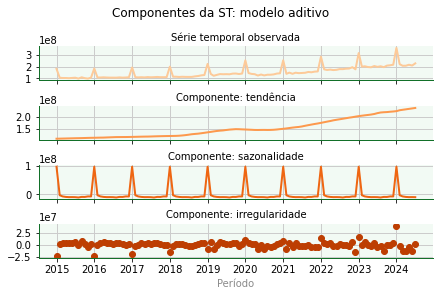

In [15]:
# componentes por modelo aditivo
df_add = seasonal_decompose(x=df_em.set_index('Período')['Total Repassado'], 
                            model='additive', 
                            extrapolate_trend='freq')

# figura
fig, ax = plt.subplots(4,1,figsize=(6,4),sharex=True,constrained_layout=True)

# plotagem das componentes
ax[0].plot(df_add.observed,color=pal[2])
ax[1].plot(df_add.trend,color=pal[4])
ax[2].plot(df_add.seasonal,color=pal[6])
ax[3].plot(df_add.resid,'o',color=pal[8])

# decoração
ax[0].set_title('Série temporal observada',fontsize=10)
ax[1].set_title('Componente: tendência',fontsize=10)
ax[2].set_title('Componente: sazonalidade',fontsize=10)
ax[3].set_title('Componente: irregularidade',fontsize=10)
ax[3].set_xlabel('Período',fontsize=10)
fig.suptitle('Componentes da ST: modelo aditivo');

- ST multiplicativa: _valor = tendência x ciclo x sazonalidade x irregularidade_

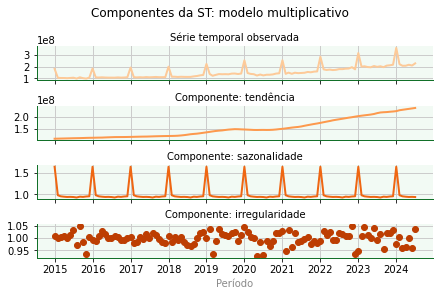

In [16]:
# componentes por modelo multiplicativo
df_mul = seasonal_decompose(x=df_em.set_index('Período')['Total Repassado'], 
                            model='multiplicative', 
                            extrapolate_trend='freq')

# figura
fig, ax = plt.subplots(4,1,figsize=(6,4),sharex=True,constrained_layout=True)

# plotagem das componentes
ax[0].plot(df_mul.observed,color=pal[2])
ax[1].plot(df_mul.trend,color=pal[4])
ax[2].plot(df_mul.seasonal,color=pal[6])
ax[3].plot(df_mul.resid,'o',color=pal[8])

# decoração
ax[0].set_title('Série temporal observada',fontsize=10)
ax[1].set_title('Componente: tendência',fontsize=10)
ax[2].set_title('Componente: sazonalidade',fontsize=10)
ax[3].set_title('Componente: irregularidade',fontsize=10)
ax[3].set_xlabel('Período',fontsize=10)
fig.suptitle('Componentes da ST: modelo multiplicativo');

- Mecanismo de plotagem direta

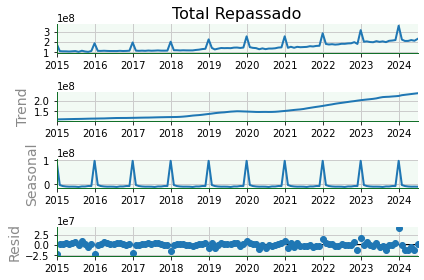

In [17]:
dp = df_add.plot()

## RV finalística

- Define função para plotar ST(s) específica(s) com alguma decoração.

In [22]:
df['Entidade'].unique()

array(['FNDE', 'INCRA', 'SENAI', 'SESI', 'SENAC', 'SESC', 'SEBRAE',
       'EMBRATUR', 'DPC', 'ANAC', 'SENAR', 'SEST', 'SENAT', 'SESCOOP',
       'SDR', 'APEX-BR', 'ABDI'], dtype=object)

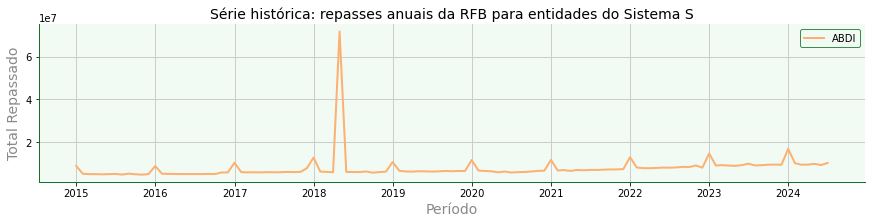

In [30]:
# entidades do sistema S
S = ['ABDI']

fig, ax = plt.subplots(figsize=(12,3),constrained_layout=True)

# plotagens individuais
for i,s in enumerate(S):
    s1 = dcs27.plot_ts_rfb(df,s,ax,pal[i+3]) # função auxiliar

ax.set_title(f'Série histórica: repasses anuais da RFB para entidades do Sistema S',fontsize=14);